<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Tutorial_LSTM_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence-to-Sequence LSTM Autoencoders**

In this tutorial, we try to detect anomalies in the AstraZeneca historical stock price time series data with an LSTM autoencoder. The selected time period is from 1993-05-12 to 2021–06–15.

The steps we will follow to detect anomalies in the AstraZeneca historical stock price data using an LSTM autoencoder:


*   We train an LSTM autoencoder on the AstraZeneca historical stock price data. We assume that there were no anomalies and that all instances were normal.
*   We use the LSTM autoencoder to reconstruct the error on the test data.
*   If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.


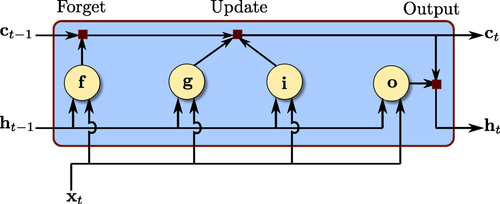

**Import Python Modules**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.5.0


**Load and Prepare Data**

In [ ]:
#Upload files into Colaboratory
from google.colab import files
uploaded = files.upload()

Saving AZN.csv to AZN.csv


In [42]:
df = pd.read_csv('AZN.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()
print(df.head(10))

        Date     Close
0 1993-05-12  5.041667
1 1993-05-13  4.854167
2 1993-05-14  4.791667
3 1993-05-17  4.895833
4 1993-05-18  4.854167
5 1993-05-19  4.875000
6 1993-05-20  4.875000
7 1993-05-21  4.875000
8 1993-05-24  4.833333
9 1993-05-25  4.812500


**Visualize the timeseries**

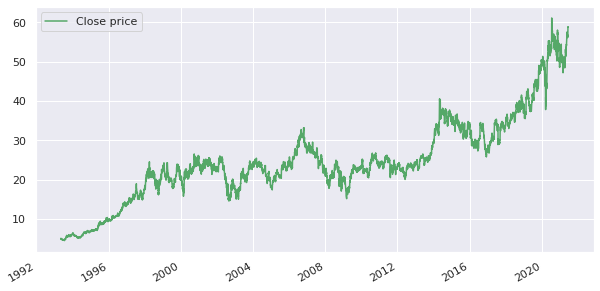

In [59]:
# use seaborn plotting style defaults
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10, 5)
df.plot(x="Date", y="Close",color='g')
plt.xlabel('')
plt.legend(['Close price'])

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='AstraZeneca Stock Price 1993-2021')
fig.show()

**Preprocessing**

In [61]:
#Training/test split
train, test = df.loc[df['Date'] <= '2021-06-15'], df.loc[df['Date'] > '2015-01-10']
train.shape, test.shape

((7075, 2), (1618, 2))

In [ ]:
#Standardize the data
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

**Create sequences**

Convert input data into 3-D array combining TIME_STEPS. The shape of the array should be [samples, TIME_STEPS, features], as required for LSTM network.

We want our network to have memory of 30 days, so we set TIME_STEPS=30.

In [63]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (7045, 30, 1)
Testing shape: (1588, 30, 1)


**Build the Model**

In [64]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))

#Compile the autoencoder with Adam optimizer, and using MAE as loss function
model.compile(optimizer='adam', loss='mae')

#Display the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

**Train the Model**

In [65]:
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
                    shuffle=False)


Epoch 1/100
199/199 [==============================] - 5s 11ms/step - loss: 0.1280 - val_loss: 0.2450
Epoch 2/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0795 - val_loss: 0.1423
Epoch 3/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0704 - val_loss: 0.1197
Epoch 4/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0656 - val_loss: 0.1231
Epoch 5/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0627 - val_loss: 0.0858
Epoch 6/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0591 - val_loss: 0.1003
Epoch 7/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0622 - val_loss: 0.1137
Epoch 8/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0559 - val_loss: 0.1237


**Plot the Loss Functions**

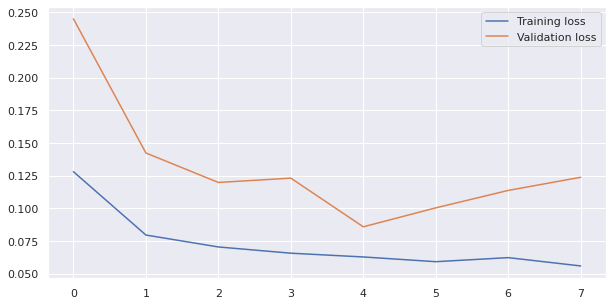

In [66]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

**Evaluate the Model**

In [67]:
model.evaluate(X_test, y_test)

50/50 [==============================] - 0s 4ms/step - loss: 0.0744


0.07443994283676147

**Determine Anomalies**

*   Find MAE loss on the training data.
*   Make half the max MAE loss value in the training data as the reconstruction error threshold.
*   If the reconstruction loss for a data point in the test set is greater than this reconstruction error threshold value then we will label this data point as an anomaly.








Reconstruction error threshold: 0.42294752377711153


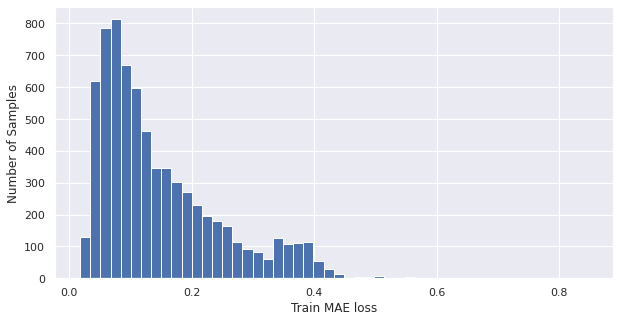

In [68]:
#Training set
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)/2
print(f'Reconstruction error threshold: {threshold}')

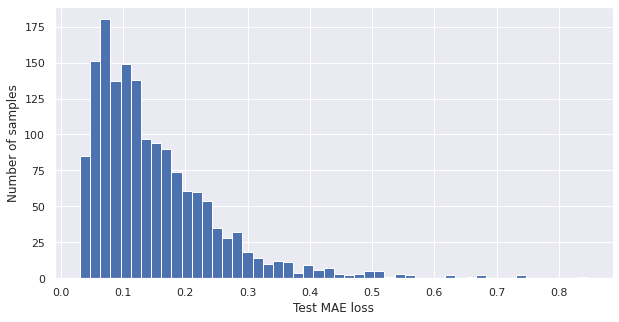

In [69]:
#Test set
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [70]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']
test_score_df.tail()

,Date,Close,loss,threshold,anomaly
7070,2021-06-09,3.088699,0.192927,0.422948,False
7071,2021-06-10,3.204976,0.172980,0.422948,False
7072,2021-06-11,3.198412,0.151225,0.422948,False
7073,2021-06-14,3.197474,0.147598,0.422948,False
7074,2021-06-15,3.204976,0.148333,0.422948,False


In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [72]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
6748,2020-02-28,1.794651,0.435793,0.422948,True
6749,2020-03-02,1.988758,0.549698,0.422948,True
6750,2020-03-03,1.955938,0.462796,0.422948,True
6758,2020-03-13,1.652118,0.619462,0.422948,True
6759,2020-03-16,1.231083,0.625803,0.422948,True


In [73]:
anomalies.shape

(39, 5)

Therefore, there are 39 data points in the test set that exceeded the reconstruction error threshold.

**Visualize Anomalies**

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()